In [8]:
import warnings
from gensim import corpora, models, similarities
from gensim.corpora import Dictionary
from gensim import corpora, models
import numpy as np
import pandas as pd
import re
from tqdm import tqdm
import jieba
tqdm.pandas()
warnings.filterwarnings('ignore')


In [9]:
train_data = pd.read_excel('新闻.xls')
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384 entries, 0 to 383
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   标题      384 non-null    object
 1   内容      383 non-null    object
 2   链接      384 non-null    object
dtypes: object(3)
memory usage: 9.1+ KB


In [10]:
print(train_data[train_data[['标题','内容']].isnull().T.any()][['标题','内容']])

                     标题   内容
0  \n攀枝花热点\n来源：攀枝花日报社\n  NaN


In [11]:
train_data=train_data.drop([0])

In [12]:
# 合并标题和正文
train_data['text'] = train_data['标题']+'\n'+train_data['内容']
train_data['text'] 

1      东区三个倾情打造营造双拥氛围\n非钒钛度讯（杨斌 记者 胡波 文/图）5月8日，记者从东区退...
2      为农民工追回欠薪140余万元！东区创新探索“劳保联动”监管机制\n非钒钛度讯（孙焕朝 徐清 ...
3      银江镇投入260万元治理污水\n非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记...
4      银江镇投入260万元治理污水\n非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记...
5      东区开展“5·12全国防灾减灾日”主题宣传活动\n非钒钛度讯（赵雪莉　记者　胡波 文/图）今...
                             ...                        
379    多举措推动城乡低保管理工作规范化\n非钒钛度讯（张正泽　记者　程礼攀）今年以来，米易县民政局...
380    米易县市场监督管理局开展“打假护农保春耕”农资产品监督抽检行动\n非钒钛度讯（张正泽　记者　...
381    湾丘彝族乡  组织两癌筛查守护女性健康\n非钒钛度讯（记者　程礼攀）近日，湾丘彝族乡妇联积极...
382    乡村里的展销会\n非钒钛度讯（王珺玮　记者　程礼攀　文/图）新鲜蔬果、高山牛肉、湾崃柑橘、平...
383    赠爱心药品 显企业担当\n非钒钛度讯（徐金霞 记者 程礼攀 文/图）近日，米易县举行零售药店...
Name: text, Length: 383, dtype: object

In [13]:
train_data['text'].isnull().any()

False

In [14]:
#句子长度分析
train_data['text_len'] = train_data['text'].apply(lambda x: len(x.split('。')))
print(train_data['text_len'].describe())

count    383.000000
mean      11.757180
std        6.310138
min        4.000000
25%        7.000000
50%       10.000000
75%       14.000000
max       44.000000
Name: text_len, dtype: float64


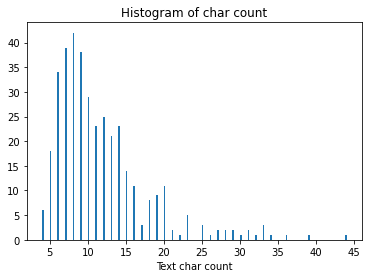

In [15]:
#句数直方图
import matplotlib.pyplot as plt
_ = plt.hist(train_data['text_len'], bins=200)
plt.xlabel('Text char count')
plt.title("Histogram of char count")
plt.savefig('./text_chart_count.png')
plt.show()

In [55]:
#去停用词，且分词
stopword_list = [k.strip() for k in open('cn_stopwords.txt', encoding='utf8').readlines() if k.strip() != '']
def clearTxt(line):
    if line != '':
        line = str(line).strip()
        #去除文本中的英文和数字
        line = re.sub("[a-zA-Z0-9]", "", line)
        #只保留中文、大小写字母
        reg = "[^0-9A-Za-z\u4e00-\u9fa5]"
        line = re.sub(reg, '', line)
        #分词
        segList = jieba.cut(line, cut_all=False)
        segSentence = ''
        for word in segList:
            if word != '\t':
                segSentence += word + " "
    # 去停用词
    wordList = segSentence.split(' ')
    sentence = ''
    for word in wordList:
        word = word.strip()
        if word not in stopword_list:
            if word != '\t':
                sentence += word + " "
    return sentence.strip()

train_data['text'] = train_data['text'].progress_apply(clearTxt)

100%|███████████████████████████████████████████████████████████████████████████████| 383/383 [00:03<00:00, 119.96it/s]


In [56]:
train_data.head()

,标题,内容,链接,text,text_len,label
1,东区三个倾情打造营造双拥氛围,非钒钛度讯（杨斌 记者 胡波 文/图）5月8日，记者从东区退役军人事务局获悉，近年来，东区倾...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 三个 倾情 打造 营造 双拥 氛围 非 钒 钛度 讯 杨斌 记者 胡波 文图 月 日 ...,14,1
2,为农民工追回欠薪140余万元！东区创新探索“劳保联动”监管机制,非钒钛度讯（孙焕朝 徐清 记者 胡波 文/图）5月8日，记者从东区区委政法委获悉，东区以市域...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,农民工 追回 欠薪 余万元 东区 创新 探索 劳保 联动 监管 机制 非 钒 钛度 讯 孙焕...,15,1
3,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,1
4,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,1
5,东区开展“5·12全国防灾减灾日”主题宣传活动,非钒钛度讯（赵雪莉 记者 胡波 文/图）今年5月12日是我国第15个全国防灾减灾日，5月6日...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 开展 全国 防灾 减灾 日 主题 宣传 活动 非 钒 钛度 讯 赵雪莉 记者 胡波 文...,12,1


<AxesSubplot:xlabel='words'>

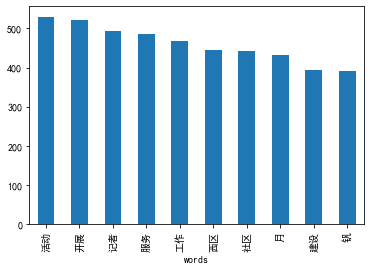

In [57]:
#词频统计
from pylab import *
from matplotlib.font_manager import FontProperties  
mpl.rcParams['font.sans-serif'] = ['SimHei']
all_words = [i.strip() for line in train_data.text for i in line.split(' ')]
all_df = pd.DataFrame({'words':all_words})
all_df.groupby(['words'])['words'].count().sort_values(ascending = False)[:10].plot.bar()  #表示停用词去除完全，分词效果尚可


### 为构建模型准备

In [58]:
#添加标数字标签
#标签初始化
train_data['label']=0
train_data.head()

,标题,内容,链接,text,text_len,label
1,东区三个倾情打造营造双拥氛围,非钒钛度讯（杨斌 记者 胡波 文/图）5月8日，记者从东区退役军人事务局获悉，近年来，东区倾...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 三个 倾情 打造 营造 双拥 氛围 非 钒 钛度 讯 杨斌 记者 胡波 文图 月 日 ...,14,0
2,为农民工追回欠薪140余万元！东区创新探索“劳保联动”监管机制,非钒钛度讯（孙焕朝 徐清 记者 胡波 文/图）5月8日，记者从东区区委政法委获悉，东区以市域...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,农民工 追回 欠薪 余万元 东区 创新 探索 劳保 联动 监管 机制 非 钒 钛度 讯 孙焕...,15,0
3,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,0
4,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,0
5,东区开展“5·12全国防灾减灾日”主题宣传活动,非钒钛度讯（赵雪莉 记者 胡波 文/图）今年5月12日是我国第15个全国防灾减灾日，5月6日...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 开展 全国 防灾 减灾 日 主题 宣传 活动 非 钒 钛度 讯 赵雪莉 记者 胡波 文...,12,0


In [59]:
for i in range(1,len(train_data)+1):
    if 'dq' in train_data['链接'][i]:
        train_data['label'][i]=1
    elif 'xq'in train_data['链接'][i]:
        train_data['label'][i]=2
    elif 'rhq' in train_data['链接'][i]:
        train_data['label'][i]=3
    elif 'my' in train_data['链接'][i]:
        train_data['label'][i]=4
train_data

,标题,内容,链接,text,text_len,label
1,东区三个倾情打造营造双拥氛围,非钒钛度讯（杨斌 记者 胡波 文/图）5月8日，记者从东区退役军人事务局获悉，近年来，东区倾...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 三个 倾情 打造 营造 双拥 氛围 非 钒 钛度 讯 杨斌 记者 胡波 文图 月 日 ...,14,1
2,为农民工追回欠薪140余万元！东区创新探索“劳保联动”监管机制,非钒钛度讯（孙焕朝 徐清 记者 胡波 文/图）5月8日，记者从东区区委政法委获悉，东区以市域...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,农民工 追回 欠薪 余万元 东区 创新 探索 劳保 联动 监管 机制 非 钒 钛度 讯 孙焕...,15,1
3,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,1
4,银江镇投入260万元治理污水,非钒钛度讯（刘贵梅 倪昕瑜 记者 胡波 文/图）5月8日，记者从东区银江镇获悉，自2019年...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,银江镇 投入 万元 治理 污水 非 钒 钛度 讯 刘贵梅 倪昕瑜 记者 胡波 文图 月 日 ...,15,1
5,东区开展“5·12全国防灾减灾日”主题宣传活动,非钒钛度讯（赵雪莉 记者 胡波 文/图）今年5月12日是我国第15个全国防灾减灾日，5月6日...,http://www.pzhnews.org/qwfbhj/qxxw/dq/202305/t...,东区 开展 全国 防灾 减灾 日 主题 宣传 活动 非 钒 钛度 讯 赵雪莉 记者 胡波 文...,12,1
...,...,...,...,...,...,...
379,多举措推动城乡低保管理工作规范化,非钒钛度讯（张正泽 记者 程礼攀）今年以来，米易县民政局在“民政为民、民政爱民”工作理念引领...,http://www.pzhnews.org/qwfbhj/qxxw/my/202301/t...,举措 推动 城乡 低保 管理工作 规范化 非 钒 钛度 讯 张正泽 记者 程礼 攀 今年以来...,13,4
380,米易县市场监督管理局开展“打假护农保春耕”农资产品监督抽检行动,非钒钛度讯（张正泽 记者 程礼攀）近日，米易县市场监督管理局在县域内开展了“打假护农保春耕”...,http://www.pzhnews.org/qwfbhj/qxxw/my/202301/t...,米易县 市场 监督 管理局 开展 打假 护农保 春耕 农资 产品 监督 抽检 行动 非 钒 ...,5,4
381,湾丘彝族乡 组织两癌筛查守护女性健康,非钒钛度讯（记者 程礼攀）近日，湾丘彝族乡妇联积极组织全乡适龄妇女参加“两癌”免费筛查，为广...,http://www.pzhnews.org/qwfbhj/qxxw/my/202301/t...,湾 丘 彝族 乡 组织 两癌 筛查 守护 女性 健康 非 钒 钛度 讯 记者 程礼 攀 近日...,11,4
382,乡村里的展销会,非钒钛度讯（王珺玮 记者 程礼攀 文/图）新鲜蔬果、高山牛肉、湾崃柑橘、平阳蔗糖……近日，米...,http://www.pzhnews.org/qwfbhj/qxxw/my/202301/t...,乡村 里 展销会 非 钒 钛度 讯 王珺玮 记者 程礼 攀文图 新鲜 蔬果 高山 牛肉 湾 ...,10,4


In [60]:
train_data['label'].value_counts()

2    96
3    96
4    96
1    95
Name: label, dtype: int64

### 构建数据集与测试集

In [88]:
from sklearn.model_selection import train_test_split
X=train_data['text']
y=train_data['label']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25)
print('训练集样本数：{}测试集样本数:{}'.format(y_train.shape[0],y_test.shape[0]))

训练集样本数：287测试集样本数:96


### 特征选择

In [110]:
from sklearn.feature_extraction.text import TfidfVectorizer
#TfidVectorizer()对X向量化操作
vec=TfidfVectorizer(ngram_range=(1,2))
#ngram_range对切分的一维和二维元组再进行向量化，减少语句本来不同但切分出相同词带来的误差
X_train_tran=vec.fit_transform(X_train)
X_test_tran=vec.transform(X_test)
display(X_train_tran,X_test_tran)

<287x62016 sparse matrix of type '<class 'numpy.float64'>'
	with 100940 stored elements in Compressed Sparse Row format>

<96x62016 sparse matrix of type '<class 'numpy.float64'>'
	with 15008 stored elements in Compressed Sparse Row format>

In [111]:
from sklearn.feature_selection import f_classif
f_classif(X_train_tran,y_train)

(array([2.59381507, 1.11753775, 1.11753775, ..., 0.9590473 , 0.71085257,
        0.71085257]),
 array([0.05287476, 0.34228099, 0.34228099, ..., 0.41248251, 0.546207  ,
        0.546207  ]))

In [112]:
from sklearn.feature_selection import SelectKBest
X_train_tran=X_train_tran.astype(np.float32)
X_test_tran=X_test_tran.astype(np.float32)
selector=SelectKBest(f_classif,k=min(5000,X_train_tran.shape[1]))
selector.fit(X_train_tran,y_train)
X_train_tran=selector.transform(X_train_tran)
X_test_tran=selector.transform(X_test_tran)
print(X_train_tran.shape,X_test_tran.shape)

(287, 5000) (96, 5000)


In [122]:
#kNN
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
param={'n_neighbors':[5,7],
       'weights':['uniform','distance'],
       'p':[2]
    
}
#超参数为:n_neighbors /weight/p
# n_neighbors：取邻近点的个数k。k取1-9测试
#weight：距离的权重；uniform：一致的权重；distance：距离的倒数作为权重
#p:闵可斯基距离的p值; p=1:即欧式距离；p=2:即曼哈顿距离；p取1-6测试
#只有当weight=distance的时候，p值才有意义
gs=GridSearchCV(estimator=KNeighborsClassifier(),param_grid=param,
               cv=3,scoring='f1',n_jobs=1,verbose=10)
gs.fit(X_train_tran,y_train)
print(gs.best_params_)
y_hat=gs.best_estimator_.predict(X_test_tran)
print(classification_report(y_test,y_hat))

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3; 1/4] START n_neighbors=5, p=2, weights=uniform.........................
[CV 1/3; 1/4] END n_neighbors=5, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 2/3; 1/4] START n_neighbors=5, p=2, weights=uniform.........................
[CV 2/3; 1/4] END n_neighbors=5, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 3/3; 1/4] START n_neighbors=5, p=2, weights=uniform.........................
[CV 3/3; 1/4] END n_neighbors=5, p=2, weights=uniform;, score=nan total time=   0.0s
[CV 1/3; 2/4] START n_neighbors=5, p=2, weights=distance........................
[CV 1/3; 2/4] END n_neighbors=5, p=2, weights=distance;, score=nan total time=   0.0s
[CV 2/3; 2/4] START n_neighbors=5, p=2, weights=distance........................
[CV 2/3; 2/4] END n_neighbors=5, p=2, weights=distance;, score=nan total time=   0.0s
[CV 3/3; 2/4] START n_neighbors=5, p=2, weights=distance........................
[CV 3/3; 2/4] END n_neighbo

### 贝叶斯算法

In [89]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data['text'].values, train_data['label'].values, random_state=1)

#x_train = x_train.flatten()
x_train[0][1]

words = []
for line_index in range(len(x_train)):
    try:
        #x_train[line_index][word_index] = str(x_train[line_index][word_index])
        words.append(' '.join(x_train[line_index]))
    except:
        print (line_index,word_index)
words     

['西 区   扎 实   推 进   药 品   网 络   监 管   非   钒   钛 度   讯   徐 浩 田   记 者   周 越   文 图   日 前   西 区   市 场   监 管 局   围 绕   药 品   网 络   销 售   突 出   问 题   线   上 线   一 致   原 则   开 展   春 雷   行 动   专 项   行 动   扎 实   推 进   药 品   网 络   销 售   监 管   进 一 步   规 范   药 品   网 络   销 售   行 为   净 化   药 品   网 络   销 售 市 场   切 实   保 障   网 络   销 售   药 品   质 量   安 全   执 法 人 员   网 上   药 品   该 局   组 织   辖 区   家   药 品   经 营   企 业   参 加   药 品   网 络   销 售   监 督 管 理   办 法   专 题 学 习   培 训   指 导   零 售   企 业   落 实   药 品   网 络   销 售   具 体   要 求   增 强   企 业   法 律 意 识   严 格   履 行   主 体   责 任   督 促   指 导   辖 区   药 品   网 络   销 售   企 业   主 动   报 告   企 业   名 称   网 站   名 称   地 址   入 驻   第 三 方   平 台   信 息   域 名   药 品   经 营   许 可 证   信 息   建 立   完 善   药 品   网 络   销 售   企 业   监 管   台 账   明 确   监 管   底 数   确 保   监 管   精 度   药 品   网 络   销 售   监 督 管 理   办 法   药 品   网 络   销 售   禁 止   清 单   第 一 版   药 品   经 营   质 量   管 理   规 范   附 录   药 品   零 售   配 送   质 量   管 理   相 关   要 求   该 局   重 点   围 绕   是 否   销 售   假 劣   药 品   禁 售   清 单   药 品   销 售   

In [90]:
# 统计有多少个词
#获得特征长度
world_len=[]
for i in words:
    x=len(i)
    world_len.append(x)
max(world_len)

4793

### 制作词袋模型特征

In [91]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer(analyzer='char', max_features=5000,  lowercase = False) #限制条件max_features特征最大长度
feature = vec.fit_transform(words)

In [92]:
test_words = []
for line_index in range(len(x_test)):
    try:
        #
        test_words.append(' '.join(x_test[line_index]))
    except:
         print (line_index,word_index)
test_words[0]

'西 区   高 质 量   发 展   建 设   共 同 富 裕   试 验 区   正 式   启 动   非   钒   钛 度   讯   徐 浩 田   记 者   周 越   月   日   西 区   召 开   高 质 量   发 展   建 设   共 同 富 裕   试 验 区   启 动   大 会   深 入   贯 彻 落 实   党   二 十 大   精 神   党 中 央   省 委   市 委   决 策   部 署   系 统   安 排   共 同 富 裕   试 验 区   重 点   工 作   动 员   全 区   统 一   思 想   凝 聚   共 识   强 有 力   举 措   推 动   共 同 富 裕   试 验 区   建 设   加 快   破 题   起 步   成 势   见 效   会 议   指 出   高 质 量   发 展   建 设   共 同 富 裕   试 验 区   贯 彻 落 实   习 近 平   新   时 代   中 国   特 色   社 会 主 义   思 想   具 体   行 动   全 面   贯 彻 落 实   省 委   市 委   决 策   部 署   重 大   举 措   加 快   建 设   一 区   一 城   现 实   需 要   西 区   当 前   今 后   一 段   时 期   重 要   任 务   全 市   同 步   高 质 量   发 展   建 设   共 同 富 裕   试 验 区   全 区   务 必   在 思 想 上   真 正   统 一 认 识   真 正   到 位   行 动   真 正   落 地   全 市   经 济 社 会   发 展   实 现   系 统 性   历 史 性   跨 越   贡 献   西 区   力 量   会 议   强 调   认 真   对 标   对 表   市 委   扎 实   推 进   共 同 富 裕   决 定   实 施 方 案   切 实   高 质 量   发 展   建 设   共 同 富 裕   试 验 区   目 标   任 务   工 作   要 求   领 会   落 实   努 力   形 成   一 批   复 制   推 广  

In [93]:
#模型评估
classifier.score(vec.transform(test_words), y_test)

0.46875

### 使用TF-IDF特征建模

In [94]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer='char', max_features=5000,  lowercase = False)
vectorizer.fit(words)

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
classifier.fit(vectorizer.transform(words), y_train)

classifier.score(vectorizer.transform(test_words), y_test)

0.4583333333333333